# Import Libraries

In [7]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

In [6]:
# Look at stock data
stk = "AMZN"

df = yf.download(stk, period="5y")

df.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2025-01-21,228.899994,231.779999,226.940002,230.710007,230.710007,39951500
2025-01-22,232.020004,235.440002,231.190002,235.009995,235.009995,41448200
2025-01-23,234.100006,235.520004,231.509995,235.419998,235.419998,26404400
2025-01-24,234.500000,236.399994,232.929993,234.850006,234.850006,25874200
2025-01-27,226.270004,235.610001,225.937698,235.419998,235.419998,49071690


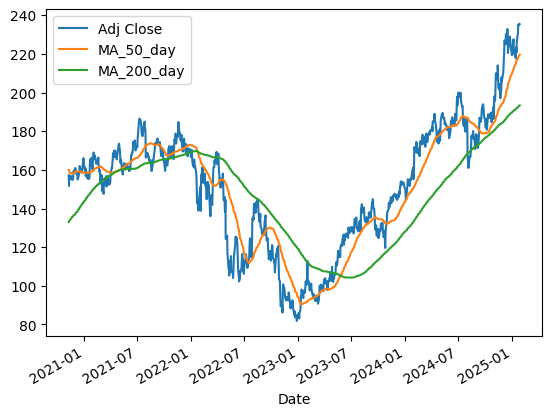

In [17]:
# Look at moving averages
df["MA_50_day"] = df["Close"].rolling(50).mean()
df["MA_200_day"] = df["Close"].rolling(200).mean()

df[["Adj Close", "MA_50_day", "MA_200_day"]].dropna().plot();

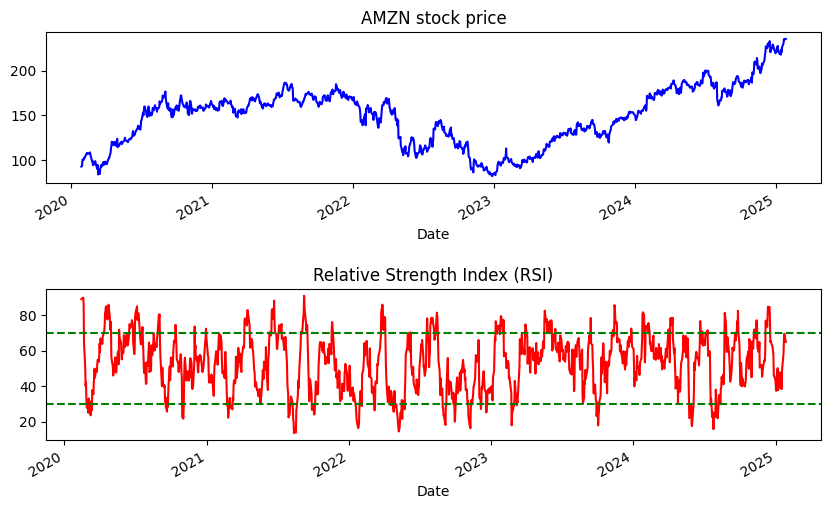

Date
2025-01-21    1.411348
2025-01-22    1.947476
2025-01-23    2.276272
2025-01-24    2.114242
2025-01-27    1.855293
Name: Close, dtype: float64

In [ ]:
# Calculate the RSI (Relative Strength Index), tells us if the stock is overbought or oversold
delta = df["Close"].diff()

gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

# Find average gains and losses
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()

# RS = avg_gain / avg_loss, high values means strong up trend, small values mean strong down trend, value close to 1 means neutral
rs = avg_gain / avg_loss

rsi = 100 - (100 / (1 + rs))

df["rsi"] = rsi

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
df["Close"].plot(title="AMZN stock price", color="blue")
plt.subplot(2, 1, 2)
df["rsi"].plot(title="Relative Strength Index (RSI)", color='red')
plt.axhline(70, color='green', linestyle="--")
plt.axhline(30, color='green', linestyle='--')
plt.subplots_adjust(hspace=.7)
plt.show()

When the red line jumps above 70, this indicates the stock is overbought and likely to drop. If the red line is below 30, this indicates the stock is oversold and is likely to jump back up in price. 

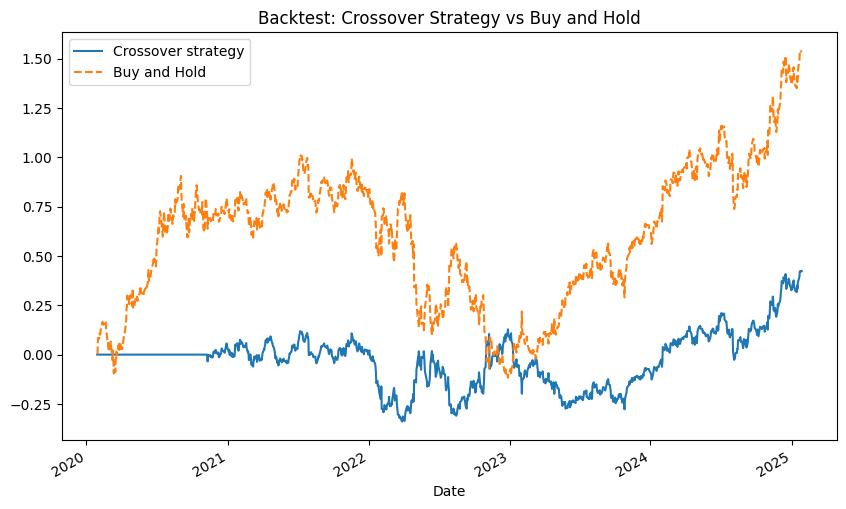

In [32]:
# Implement basic strategy, cross-over strategy
df["Signal"] = 0
df.loc[df["MA_50_day"] > df["MA_200_day"], "Signal"] = 1        # Time to buy, bullish
df.loc[df["MA_50_day"] < df["MA_200_day"], "Signal"] = -1       # Time to sell, bearish

df["Daily_Return"] = df["Close"].pct_change()

df["Strategy_Return"] = df["Daily_Return"] * df["Signal"].shift(1)

df["Cumulative_Strategy_Returns"] = (1 + df["Strategy_Return"]).cumprod() - 1
df["Cumulative_Buy_Hold_Returns"] = (1 + df["Daily_Return"]).cumprod() - 1          # This determines the return by simplying buying and holding, acts as benchmark

plt.figure(figsize=(10, 6))
df["Cumulative_Strategy_Returns"].plot(label="Crossover strategy")
df["Cumulative_Buy_Hold_Returns"].plot(label="Buy and Hold", linestyle="--")
plt.legend()
plt.title("Backtest: Crossover Strategy vs Buy and Hold")
plt.show()



This plot shows that the simple crossover strategy performed more poorly than simply buying and holding the shares over the length of time.

# Implementing basic risk management rules

#### Stop-loss - Prevents big losses by selling a position if the stock price falls a certain percentage from buy position (i.e. 3%)
#### Take-profit - Locks in profits by selling position if price rises above a percentage from buy position

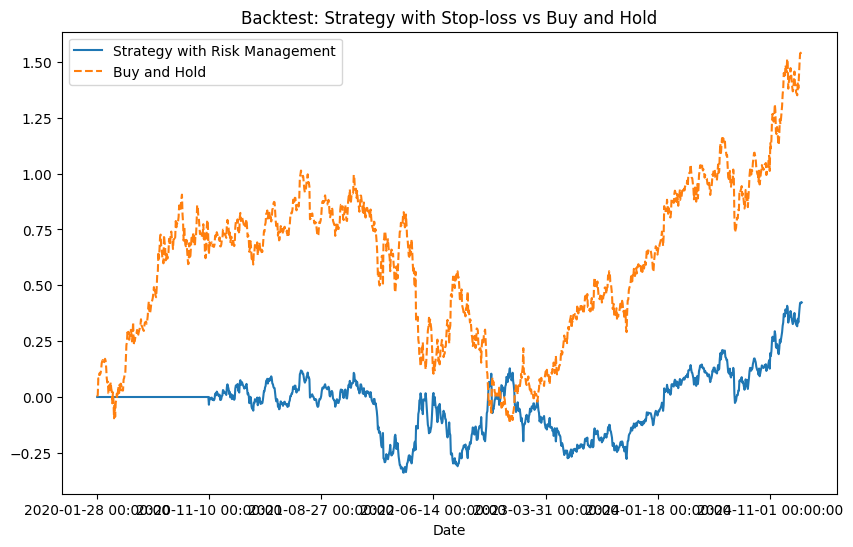

In [47]:
stop_loss_pct = 0.03
take_profit_pct = 0.05

df["Stop_Loss"] = 0.0
df["Take_Profit"] = 0.0

df["Stop_Loss"] = df["Stop_Loss"].astype(float)
df["Take_Profit"] = df["Take_Profit"].astype(float)

entry_price = 0
in_position = False

for i in range(1, len(df)):
    if df["Signal"].iloc[i] == 1 and not in_position:  # Buy signal
        entry_price = df["Close"].iloc[i]
        df.loc[i, "Stop_Loss"] = entry_price * (1 - stop_loss_pct)  # Set stop-loss price
        df.loc[i, "Take_Profit"] = entry_price * (1 + take_profit_pct)  # Set take-profit price
        in_position = True  # Set in_position to True when position is entered

    elif in_position:  # Check if we are in a position and whether stop-loss or take-profit is triggered
        if df["Close"].iloc[i] <= df["Stop_Loss"].iloc[i] or df["Close"].iloc[i] >= df["Take_Profit"].iloc[i]:
            df.loc[i, "Signal"] = -1  # Sell signal (close position)
            in_position = False  # Exit position
            df.loc[i, "Stop_Loss"] = 0  # Reset stop-loss
            df.loc[i, "Take_Profit"] = 0  # Reset take-profit


df["Daily_Return"] = df["Close"].pct_change(fill_method=None)

df["Strategy_Return"] = df["Daily_Return"] * df["Signal"].shift(1)

df["Cumulative_Strategy_Returns"] = (1 + df["Strategy_Return"]).cumprod() - 1
df["Cumulative_Buy_Hold_Returns"] = (1 + df["Daily_Return"]).cumprod() - 1          # This determines the return by simplying buying and holding, acts as benchmark

plt.figure(figsize=(10, 6))
df["Cumulative_Strategy_Returns"].plot(label="Strategy with Risk Management")
df["Cumulative_Buy_Hold_Returns"].plot(label="Buy and Hold", linestyle="--")
plt.legend()
plt.title("Backtest: Strategy with Stop-loss vs Buy and Hold")
plt.show()